In [1]:
# pip install pipreqsnb

In [2]:
# pip install clusteval
# НЕВЕРОЯТНО ПОЛЕЗЕН

In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
import pypfopt

from sklearn.covariance import LedoitWolf
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from hdbscan import HDBSCAN
from clusteval import clusteval

from DP_functions import *

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

(CVXPY) Aug 16 10:17:21 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 16 10:17:21 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [4]:
df = pd.read_csv('NCO_data.csv', index_col='Unnamed: 0')

In [5]:
returns = pd.DataFrame(index=df.index)

for column in df.columns:
    returns[column] = df[column]/df[column].shift(1) - 1
    
returns = returns.dropna(axis=0)

In [6]:
cov0 = returns.cov()
corr0 = returns.corr()

In [7]:
cov_dnsd = deNoiseCov(cov0, q=491/403, bWidth=.05)
corr_dnsd = cov2corr(cov_dnsd)

In [8]:
lw = LedoitWolf()
cov_lw = lw.fit(cov_dnsd).covariance_
corr_lw = cov2corr(cov_lw)

<Axes: >

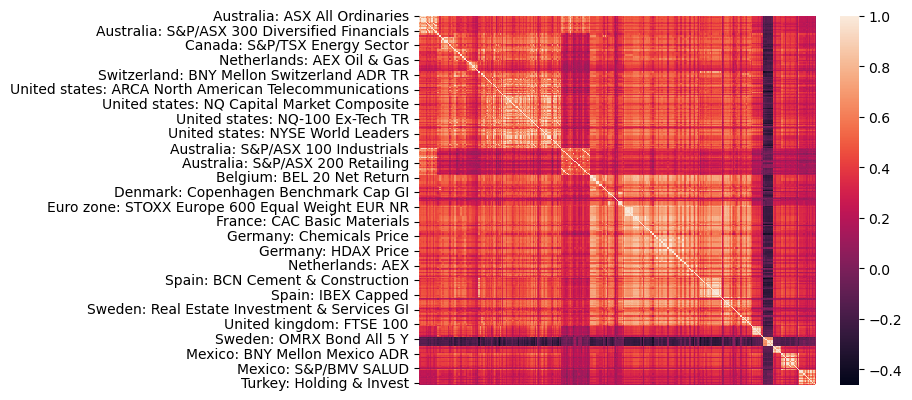

In [9]:
sns.heatmap(pd.DataFrame(corr0, index=corr0.index), annot=False, xticklabels=False)

<Axes: >

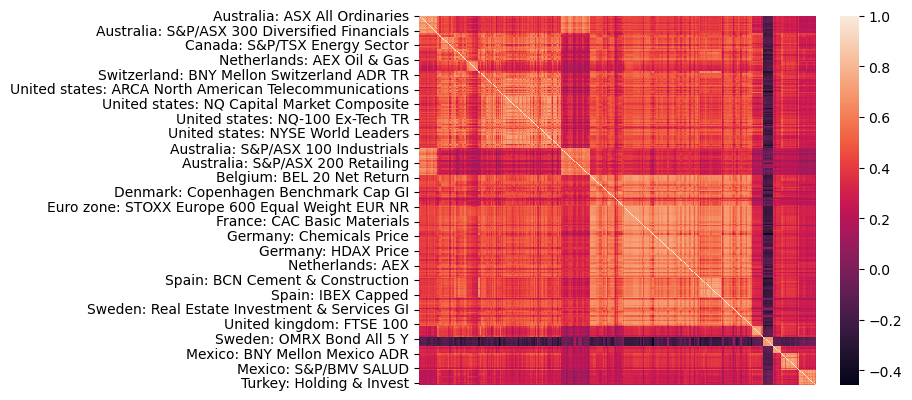

In [10]:
sns.heatmap(pd.DataFrame(corr_dnsd, index=corr0.index), annot=False, xticklabels=False)

<Axes: >

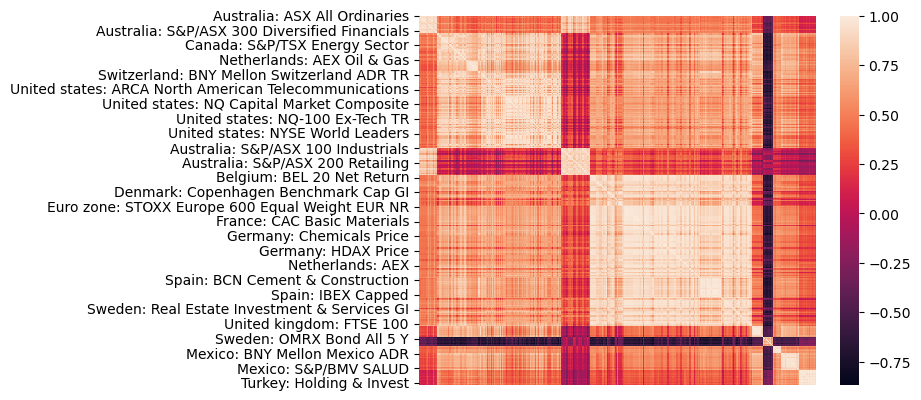

In [11]:
sns.heatmap(pd.DataFrame(corr_lw, index=corr0.index), annot=False, xticklabels=False)

In [12]:
print('Condition number of historical covariance matrix :', '{:f}'.format(CovMatCondNum(cov0)))
print('Condition number after denoising via Constant residual eigenvalue method :', CovMatCondNum(cov_dnsd))
print('Condition number after Ledoit Wolf shrinkage :', CovMatCondNum(cov_lw))

Condition number of historical covariance matrix : 3485826872800899072.000000
Condition number after denoising via Constant residual eigenvalue method : 22322.8449298109
Condition number after Ledoit Wolf shrinkage : 18034.466156118684


In [13]:
corr_df = pd.DataFrame()
i = 0
for column in cov0.columns:
    corr_df[column] = corr_lw[i]
    i += 1

In [14]:
corr_df.index = corr_df.columns

In [15]:
length = corr_df.shape[0]
prox = np.sqrt(np.ones((length, length))/2 - np.array(corr_df)/2)
np.fill_diagonal(prox, 0)

In [16]:
prox_df = pd.DataFrame()
for i in range(len(corr_df)):
    prox_df[corr_df.columns[i]] = prox[i]
prox_df.index = corr_df.columns

In [17]:
cov_df = pd.DataFrame(index=corr_df.columns, columns=corr_df.columns)
for j in range(len(corr_df)):
    cov_df[corr_df.columns[j]] = cov_lw[j]

In [18]:
ce = clusteval(cluster='hdbscan', evaluate='silhouette')
results = ce.fit(prox_df)
labels = results['labx']
labels[labels==-1] = len(set(labels)) - 1

clstrs = {}
for i in list(set(labels)):
    clstrs[i] = []

j = 0    
for i in labels:
    clstrs[i] += [corr_df.columns[j]]
    j += 1

corr_clstrd = clstrdMatrix(corr_df, clstrs)[0]
ordered_assets = clstrdMatrix(cov_df, clstrs)[1]

wIntra = pd.DataFrame(0, index=cov_df.index, columns=clstrs.keys())
for i in clstrs:
    cov_clstr_i = cov_df.loc[clstrs[i], clstrs[i]]
    wIntra.loc[clstrs[i], i] = minVarPort(cov_clstr_i).flatten()

reduced_cov = wIntra.T.dot(cov_df).dot(wIntra)
needed_clstrs = clstrs
weights = []
for i in wIntra.columns:
    weights.append(np.array(wIntra.loc[needed_clstrs[i], i]))
mean_clstr_returns = clstrs_returns(returns, needed_clstrs, weights)
wInter = optPort(reduced_cov, mu=mean_clstr_returns).flatten() 

wFinal = []
j = 0
for weight in wInter:
    wFinal += list(weight*wIntra.loc[
        needed_clstrs[j], j])
    j += 1

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[hdbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Estimated number of clusters: 49
[clusteval] >INFO> Silhouette Coefficient: 0.148
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [50].
[clusteval] >INFO> Fin.


[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=2.329. Be patient now..
[clusteval] >INFO> Compute cluster labels.


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [10.0, 10.0, 33.75, 33.75],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [21.875, 21.875, 73.75, 73.75],
  [105.0, 105.0, 115.0, 115.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [110.0, 110.0, 132.5, 132.5],
  [165.0, 165.0, 175.0, 175.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [185.0, 185.0, 202.5, 202.5],
  [225.0, 225.0, 235.0, 235.0],
  [193.75, 193.75, 230.0, 230.0],
  [170.0, 170.0, 211.875, 211.875],
  [155.0, 155.0, 190.9375, 190.9375],
  [121.25, 121.25, 172.96875, 172.96875],
  [245.0, 245.0, 255.0, 255.0],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [250.0, 250.0, 272.5, 272.5],
  [147.109375, 147.109375, 261.25, 261.25],
  [295.0, 295.0, 305.0, 305.0],
  [315.0, 315.0, 325.0, 325.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 35

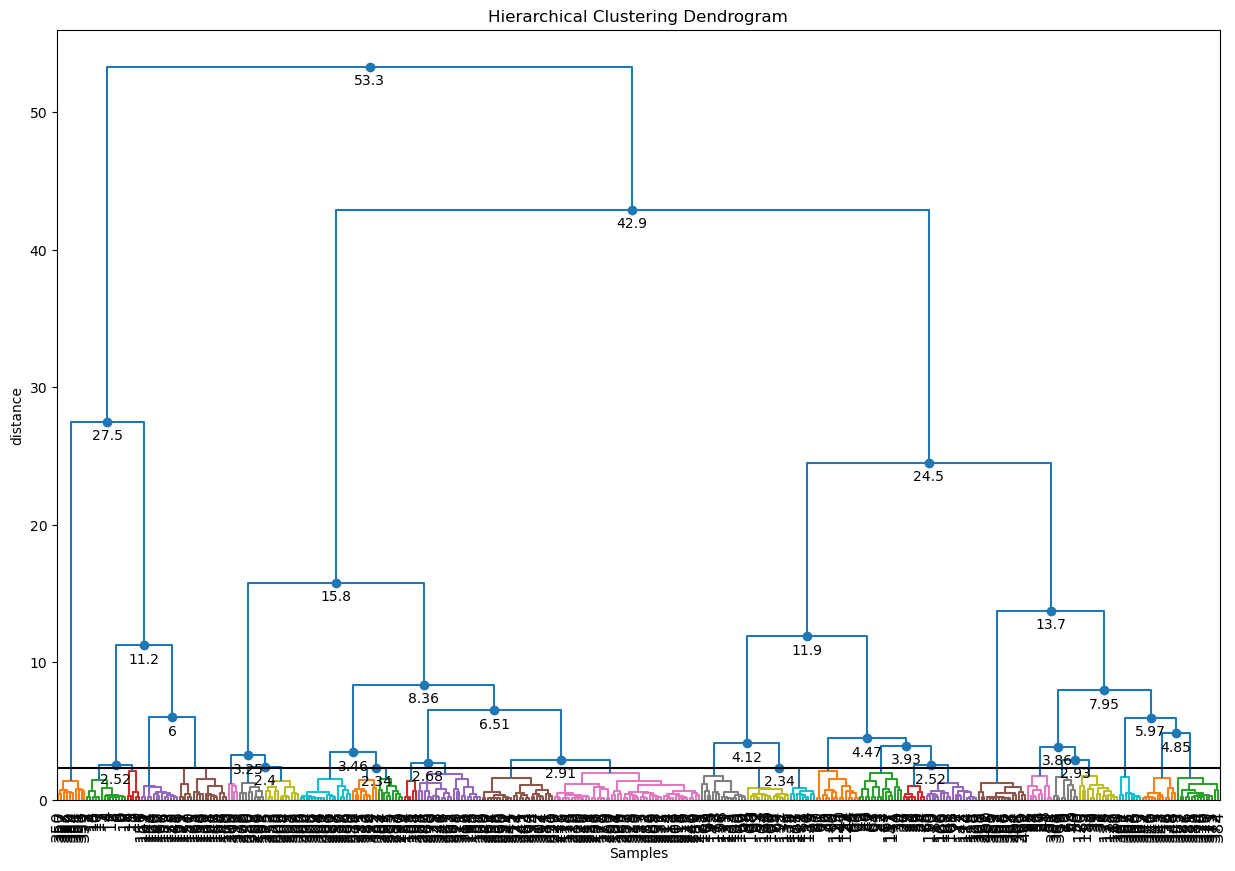

In [19]:
ce.dendrogram()

<Axes: >

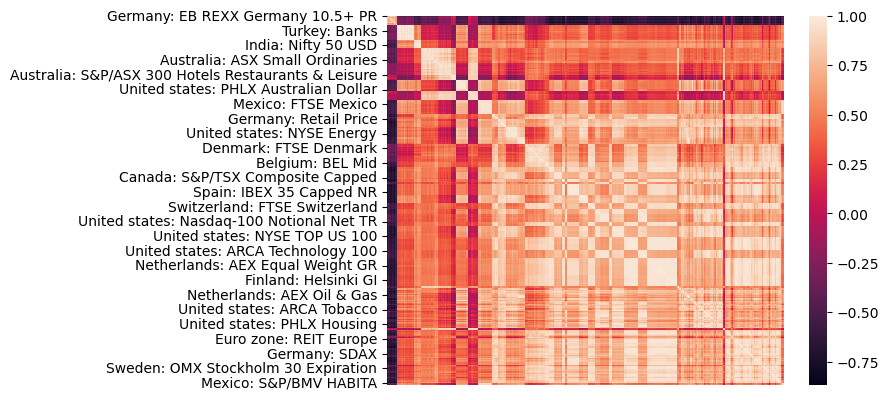

In [20]:
corr_clstrd = clstrdMatrix(pd.DataFrame(corr_lw, index=corr0.index, columns=corr0.columns), clstrs)[0]
ordered_assets = clstrdMatrix(pd.DataFrame(corr_lw, index=corr0.index, columns=corr0.columns), clstrs)[1]

sns.heatmap(corr_clstrd, xticklabels=False)

<Axes: >

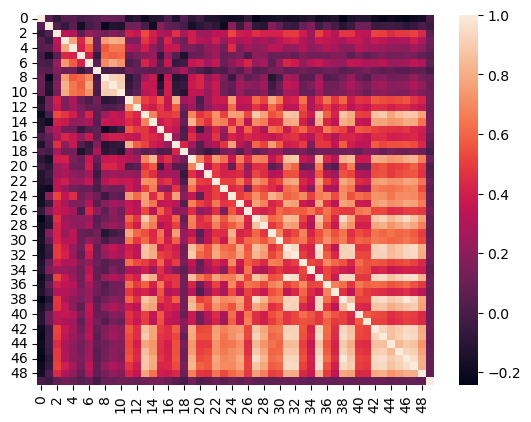

In [21]:
reduced_cov = wIntra.T.dot(cov_df).dot(wIntra)
sns.heatmap(cov2corr(reduced_cov))

In [22]:
print('Condition number of an old reduced covariance matrix :', CovMatCondNum(cov_lw))
print('Condition number of a new reduced covariance matrix :', CovMatCondNum(reduced_cov))

Condition number of an old reduced covariance matrix : 18034.466156118684
Condition number of a new reduced covariance matrix : 2473.9165744149054


In [23]:
wInter = minVarPort(reduced_cov).flatten()

In [24]:
wFinal = wIntra.dot(wInter)
wFinal = pd.Series(wFinal, index=ordered_assets)

In [25]:
wIntra.sort_values(0, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
United kingdom: FTSE Fixed Interest Up to 15 Years,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
United kingdom: FTSE Fixed Interest Up to 20 Years,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Germany: EB REXX Germany 5.5-10.5 PR,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
United kingdom: FTSE Fixed Interest 5 to 10 Years,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sweden: OMRX Bond All 5 Y,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United states: Nasdaq,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
United states: NYSE World Leaders Mini Value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
United states: NYSE World Leaders,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Germany: EB REXX Germany 10.5+ PR,-0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


<Axes: >

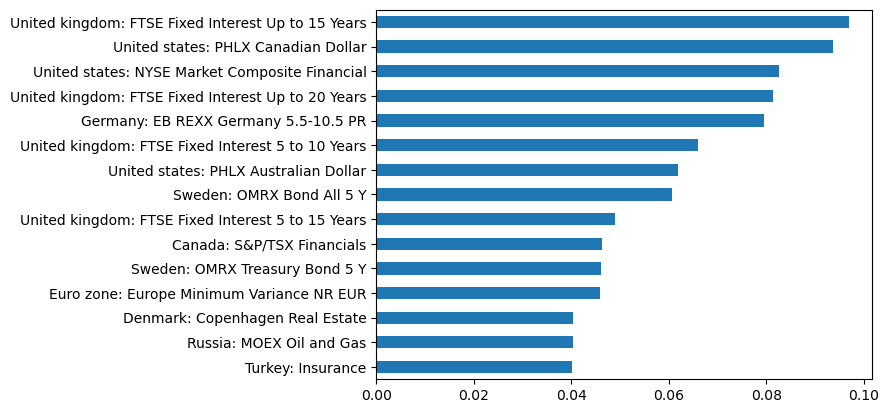

In [26]:
values = clstrdMatrix(corr_df, clstrs)[1]
top10_weights = wFinal[wFinal>0.04].sort_values(ascending=False)
top10_weights[::-1].plot(kind='barh')